## Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Import data

In [2]:
X_train = pd.read_csv('data/X_train.csv', index_col=0)
X_test = pd.read_csv('data/X_test.csv', index_col=0)
y_train = pd.read_csv('data/y_train.csv', index_col=0)
y_test = pd.read_csv('data/y_test.csv', index_col=0)

In [3]:
train_df = pd.concat([X_train, y_train], axis=1)
train_df = train_df.drop(columns = ['id', 'coordinates'])
test_df = pd.concat([X_test, y_test], axis=1)
test_df = test_df.drop(columns=['id', 'coordinates'])

## Create year features

In [4]:
#create a 'new_construction' feature
train_df['new_construction'] = (train_df['yr_built']>2009) | (train_df['yr_renovated']>2009)
test_df['new_construction'] = (test_df['yr_built']> 2009) |(test_df['yr_renovated']>2009)
train_df = train_df.drop(columns=['yr_built', 'yr_renovated'])

In [5]:
train_df['new_construction'].value_counts(normalize=True)

False    0.936717
True     0.063283
Name: new_construction, dtype: float64

In [6]:
#create new feature of total rooms in home
train_df['total_rooms'] = (train_df['bedrooms'] + train_df['bathrooms'])
test_df['total_rooms'] = (test_df['bedrooms'] + test_df['bathrooms'])

In [7]:
train_df['total_rooms'].head()

6405     5.50
937      5.50
19076    9.00
15201    4.00
13083    5.25
Name: total_rooms, dtype: float64

In [8]:
train_df.shape

(16197, 19)

In [9]:
Q1 = train_df.quantile(0.05)
Q3 = train_df.quantile(0.95)
IQR = Q3 - Q1
train_df = train_df[~((train_df < (Q1-1.5*IQR)) | (train_df> (Q3 + 1.5*IQR))).any(axis=1)]

train_df.shape

(15658, 19)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15658 entries, 6405 to 15795
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bedrooms                   15658 non-null  int64  
 1   bathrooms                  15658 non-null  float64
 2   sqft_living                15658 non-null  int64  
 3   sqft_lot                   15658 non-null  int64  
 4   floors                     15658 non-null  float64
 5   condition                  15658 non-null  object 
 6   grade                      15658 non-null  int64  
 7   sqft_above                 15658 non-null  int64  
 8   sqft_basement              15658 non-null  float64
 9   sqft_living15              15658 non-null  int64  
 10  sqft_lot15                 15658 non-null  int64  
 11  bedrooms_bathrooms         15658 non-null  float64
 12  sqft_lot_sqft_living       15658 non-null  float64
 13  sqft_living_sqft_living15  15658 non-null  

# Standarization

In [11]:
# plt.figure(figsize = (10, 10))
# sns.pairplot(train_df)

Log transform right skewed variables

In [12]:
def log_transform(df, column): 
    '''
    Input: 
    df = DataFrame
    column = column name as string
    
    Output: 
    log of values in column
    '''
    df[column] = np.log(df[column])

In [13]:
log_transform(train_df, 'price')
log_transform(test_df, 'price')

In [14]:
# log_transform(train_df, 'sqft_living_bedrooms')
# log_transform(test_df, 'sqft_living_bedrooms')

In [15]:
# log_transform(train_df, 'bedrooms_bathrooms')
# log_transform(test_df, 'bedrooms_bathrooms')

### Apply Standard Scale

In [16]:
X_train = train_df.drop(columns='price')
y_train = train_df['price']

X_test = test_df.drop(columns = 'price')
y_test = test_df['price']

In [17]:
#defining columns to be encoded vs scaled
cols_to_scale = list(X_train.select_dtypes(include='number').columns)
cols_to_encode = list(X_train.select_dtypes(exclude='number').columns)

Scaling numerical data:

In [18]:
# Instantiate a new scaler
scaler = StandardScaler()

#scale numeric columns

cols_to_scale = list(X_train.select_dtypes(include='number').columns)


scaler.fit(X_train[cols_to_scale])

train_scaled_columns = scaler.transform(X_train[cols_to_scale])
test_scaled_columns = scaler.transform(X_test[cols_to_scale])

X_train_df_num = pd.DataFrame(index=X_train.index, data=train_scaled_columns, columns=cols_to_scale)
X_test_df_num = pd.DataFrame(index=X_test.index, data=test_scaled_columns, columns=cols_to_scale)

X_train_df_num

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,sqft_living15,sqft_lot15,bedrooms_bathrooms,sqft_lot_sqft_living,sqft_living_sqft_living15,sqft_living_bedrooms,total_rooms
6405,-0.411044,0.53352,-0.198558,-0.523654,0.936781,0.324239,0.150845,-0.661679,0.238833,-0.473681,-0.857414,-0.584539,-0.547788,0.077733,0.021247
937,-0.411044,0.53352,-0.035811,-0.325726,-0.911055,-0.557939,-0.575043,0.992638,-0.388003,-0.469532,-0.857414,-0.402524,0.442834,0.307104,0.021247
15201,-1.528232,-0.13602,-0.721673,-0.582984,-0.911055,-0.557939,-0.422224,-0.661679,-0.805893,-0.612028,-1.165353,-0.516487,-0.158479,0.511900,-1.023849
13083,-0.411044,0.19875,0.254808,2.123017,-0.911055,0.324239,-0.027443,0.573234,0.507477,3.617534,-0.652121,1.913366,-0.215914,0.716696,-0.152935
16852,-2.645420,-0.80556,-1.165739,-0.494803,-0.911055,-0.557939,-0.908696,-0.661679,-1.522277,-0.508884,-1.678584,-0.119721,0.183687,2.148629,-2.068945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11964,-0.411044,0.53352,0.208309,-0.398955,0.936781,-0.557939,0.596565,-0.661679,0.388080,-0.364483,-0.857414,-0.540373,-0.158479,0.651162,0.021247
21575,0.706145,0.86829,0.836046,-0.585668,0.936781,0.324239,1.284248,-0.661679,-0.238756,-0.414597,-0.465492,-0.797595,1.600769,0.401311,0.892161
5390,0.706145,-0.80556,-0.605425,-0.092239,-0.911055,-1.440118,-0.294876,-0.661679,-0.671571,-0.094067,1.400805,0.157036,-0.136657,-1.122371,0.021247
860,-2.645420,-1.80987,-1.942273,0.482854,-0.911055,-2.322296,-1.759386,-0.661679,-1.193935,0.634665,-0.652121,7.296212,-2.398105,-1.134659,-2.591493


One Hot Encoding categorical variables:

In [19]:
cols_to_encode

['condition', 'grade_category', 'new_construction']

In [20]:
#encode categorial columns
ohe = OneHotEncoder(sparse=False)

ohe.fit(X_train[cols_to_encode])

train_encoded_columns = ohe.transform(X_train[cols_to_encode])
test_encoded_columns = ohe.transform(X_test[cols_to_encode])

ohe.get_feature_names

X_train_df_cat = pd.DataFrame(data=train_encoded_columns, index=X_train.index, columns=ohe.get_feature_names())
X_test_df_cat = pd.DataFrame(data=test_encoded_columns, index=X_test.index, columns=ohe.get_feature_names())

In [21]:
X_train_variables = pd.concat([X_train_df_num, X_train_df_cat], axis=1)
X_test_variables = pd.concat([X_test_df_num, X_test_df_cat], axis=1)

In [22]:
train_df_num = pd.concat([X_train_variables, y_train], axis=1)
test_df_num = pd.concat([X_test_variables, y_test], axis=1)
train_df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15658 entries, 6405 to 15795
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bedrooms                   15658 non-null  float64
 1   bathrooms                  15658 non-null  float64
 2   sqft_living                15658 non-null  float64
 3   sqft_lot                   15658 non-null  float64
 4   floors                     15658 non-null  float64
 5   grade                      15658 non-null  float64
 6   sqft_above                 15658 non-null  float64
 7   sqft_basement              15658 non-null  float64
 8   sqft_living15              15658 non-null  float64
 9   sqft_lot15                 15658 non-null  float64
 10  bedrooms_bathrooms         15658 non-null  float64
 11  sqft_lot_sqft_living       15658 non-null  float64
 12  sqft_living_sqft_living15  15658 non-null  float64
 13  sqft_living_bedrooms       15658 non-null  

## Models with scaled data

In [23]:
train_df_num.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'grade',
       'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       'bedrooms_bathrooms', 'sqft_lot_sqft_living',
       'sqft_living_sqft_living15', 'sqft_living_bedrooms', 'total_rooms',
       'x0_Average', 'x0_Fair', 'x0_Good', 'x0_Poor', 'x0_Very Good',
       'x1_high', 'x1_low', 'x1_medium', 'x2_False', 'x2_True', 'price'],
      dtype='object')

Not all of the features above can be changed by a person. Below lists house features that someone can change about their home. 

In [24]:
house_features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'grade', 'bedrooms_bathrooms',
                  'sqft_living_sqft_living15', 'sqft_living_bedrooms', 'total_rooms']

<AxesSubplot:>

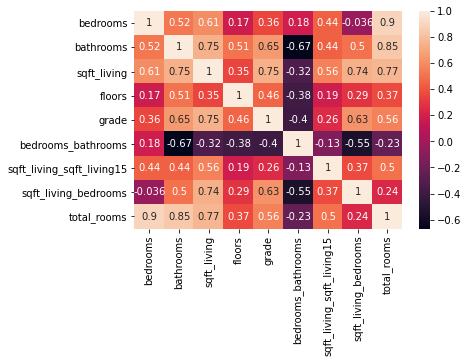

In [25]:
#review multicollinearity of variables
sns.heatmap(train_df_num[house_features].corr(), annot=True)

<AxesSubplot:>

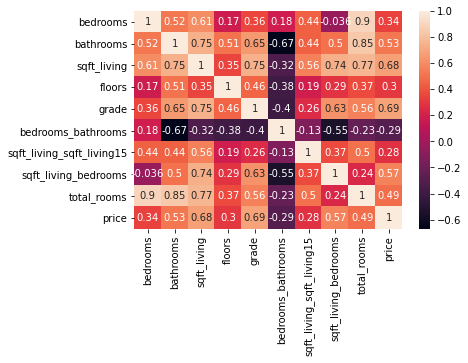

In [26]:
heatmap = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'grade', 'bedrooms_bathrooms',
                  'sqft_living_sqft_living15', 'sqft_living_bedrooms', 'total_rooms','price']
sns.heatmap(train_df_num[heatmap].corr(), annot=True)

Simple models: 

In [27]:
for feature in house_features: 
    formula = 'price ~ ' + feature
    
    model = ols(formula=formula, data=train_df_num).fit() 
    print(formula)
    print(model.rsquared)
    print('*****')

price ~ bedrooms
0.11711055030539386
*****
price ~ bathrooms
0.2797695083615864
*****
price ~ sqft_living
0.4585647107379974
*****
price ~ floors
0.0918280487374673
*****
price ~ grade
0.47226919314068605
*****
price ~ bedrooms_bathrooms
0.08612817660667083
*****
price ~ sqft_living_sqft_living15
0.07889871434803797
*****
price ~ sqft_living_bedrooms
0.3214884325562868
*****
price ~ total_rooms
0.23875656420976032
*****


price ~ grade
0.4722691931406864
*****
price ~ sqft_living
0.4585647107379971
*****
price ~ sqft_living_bedrooms
0.32513627380769616
*****
price ~ bathrooms
0.27976950836158665
*****
price ~ sqft_living_bedrooms
0.32513627380769616
*****
price ~ total_rooms
0.23875656420976044

#### Multiple variables 

In [28]:
def pro_model(features): 
    formula = 'price ~'+ "+".join(features)
    model= ols(formula=formula, data=train_df_num).fit()
    predicted_train_variable = model.predict(train_df_num)
    predicted_test_variable = model.predict(test_df_num)
    train_rmse = mean_squared_error(y_train, predicted_train_variable, squared=False)
    test_rsme = mean_squared_error(y_test, predicted_test_variable, squared=False)
    train_mean_absolute_error = mean_absolute_error(y_train, predicted_train_variable)
    test_mean_absolute_error = mean_absolute_error(y_test, predicted_test_variable)
    output = (f"{model.params}, {model.rsquared}, train_rmse: ${train_rmse},\
    test_rsme: ${test_rsme}, train_mean_absolute_error: ${train_mean_absolute_error},\
            test_mean_absolute_error: ${test_mean_absolute_error}")
    print(output)

In [29]:
# 'price ~ grade + sqft_living + bathrooms'
pro_model(['grade', 'sqft_living', 'bathrooms'])

Intercept      13.036710
grade           0.213250
sqft_living     0.198470
bathrooms      -0.015086
dtype: float64, 0.5321700486381533, train_rmse: $0.3508377456977947,    test_rsme: $0.3501026869863064, train_mean_absolute_error: $0.28307519233982426,            test_mean_absolute_error: $0.28293400327488505


In [30]:
#evaluate
pro_model(['grade', 'bathrooms'])

Intercept    13.036710
grade         0.304721
bathrooms     0.073660
dtype: float64, 0.4842154846048212, train_rmse: $0.368380345061082,    test_rsme: $0.36954983918877743, train_mean_absolute_error: $0.29540983174694985,            test_mean_absolute_error: $0.29605681171050974


In [31]:
pro_model(['sqft_living', 'bathrooms'])

Intercept      13.036710
sqft_living     0.326887
bathrooms       0.027422
dtype: float64, 0.4598318298322627, train_rmse: $0.3769873653503311,    test_rsme: $0.3760790558096747, train_mean_absolute_error: $0.3069686251424549,            test_mean_absolute_error: $0.30613125051602635


In [32]:
pro_model(['sqft_living', 'total_rooms'])

Intercept      13.036710
sqft_living     0.375591
total_rooms    -0.036896
dtype: float64, 0.4607065131074971, train_rmse: $0.3766820177224991,    test_rsme: $0.3764733249444073, train_mean_absolute_error: $0.30640595838373286,            test_mean_absolute_error: $0.30648968660741466


In [33]:
#evaluate
pro_model(house_features)

Intercept                    1.303671e+01
bedrooms                     3.475984e+11
bathrooms                    2.899998e+11
sqft_living                  9.923952e-02
floors                      -5.470062e-03
grade                        2.004477e-01
bedrooms_bathrooms           6.661759e-03
sqft_living_sqft_living15   -2.727432e-02
sqft_living_bedrooms         1.086255e-01
total_rooms                 -5.573643e+11
dtype: float64, 0.5313366696201449, train_rmse: $0.35115009286716803,    test_rsme: $0.35118985791252116, train_mean_absolute_error: $0.2829829907225244,            test_mean_absolute_error: $0.2839133387205637


In [34]:
pro_model(house_features[1:])

Intercept                    13.036710
bathrooms                    -0.047638
sqft_living                   0.099155
floors                       -0.005590
grade                         0.200418
bedrooms_bathrooms            0.006582
sqft_living_sqft_living15    -0.027294
sqft_living_bedrooms          0.108663
total_rooms                   0.094020
dtype: float64, 0.5379610810340244, train_rmse: $0.3486595617750192,    test_rsme: $0.34925595910609136, train_mean_absolute_error: $0.28191288530364744,            test_mean_absolute_error: $0.2826523906327372


In [35]:
pro_model(house_features[2:])

Intercept                    13.036710
sqft_living                   0.111497
floors                       -0.007637
grade                         0.198992
bedrooms_bathrooms            0.025024
sqft_living_sqft_living15    -0.027008
sqft_living_bedrooms          0.096992
total_rooms                   0.052730
dtype: float64, 0.5376295403941549, train_rmse: $0.34878463141779886,    test_rsme: $0.34905710219943126, train_mean_absolute_error: $0.2820904260731723,            test_mean_absolute_error: $0.28263932596006547


In [36]:
pro_model(house_features[3:])

Intercept                    13.036710
floors                       -0.011153
grade                         0.209475
bedrooms_bathrooms            0.047915
sqft_living_sqft_living15    -0.024756
sqft_living_bedrooms          0.169776
total_rooms                   0.120326
dtype: float64, 0.5353844315881402, train_rmse: $0.34963039390809103,    test_rsme: $0.3520725293455885, train_mean_absolute_error: $0.2821261243551386,            test_mean_absolute_error: $0.2834200254853778


In [37]:
pro_model(['total_rooms', 'grade'])

Intercept      13.036710
total_rooms     0.077104
grade           0.309230
dtype: float64, 0.48774959342922974, train_rmse: $0.3671161213579254,    test_rsme: $0.3682891220624057, train_mean_absolute_error: $0.29359374206493016,            test_mean_absolute_error: $0.29490767650513683


In [38]:
X_train.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15',
       'sqft_lot15', 'bedrooms_bathrooms', 'sqft_lot_sqft_living',
       'sqft_living_sqft_living15', 'sqft_living_bedrooms', 'grade_category',
       'new_construction', 'total_rooms'],
      dtype='object')

In [39]:
pro_model(['sqft_lot_sqft_living','floors'])

Intercept               13.036710
sqft_lot_sqft_living    -0.051053
floors                   0.140321
dtype: float64, 0.10086615535637966, train_rmse: $0.4863786166048168,    test_rsme: $0.5917445371693931, train_mean_absolute_error: $0.3901164815739711,            test_mean_absolute_error: $0.4151513071391013


In [40]:
pro_model(['floors', 'sqft_lot'])

Intercept    13.036710
floors        0.162654
sqft_lot      0.087499
dtype: float64, 0.1207293219026303, train_rmse: $0.48097620982076,    test_rsme: $0.5873230917787017, train_mean_absolute_error: $0.3864331722949072,            test_mean_absolute_error: $0.41877500729753003


In [41]:
pro_model(['sqft_living', 'sqft_living_bedrooms'])

Intercept               13.036710
sqft_living              0.292622
sqft_living_bedrooms     0.073775
dtype: float64, 0.4678691458559795, train_rmse: $0.37417220302322063,    test_rsme: $0.3737461147776073, train_mean_absolute_error: $0.3041824678184983,            test_mean_absolute_error: $0.3035726126395785


In [42]:
pro_model(['bedrooms', 'bathrooms', 'sqft_living_bedrooms'])

Intercept               13.036710
bedrooms                 0.157103
bathrooms                0.053483
sqft_living_bedrooms     0.269569
dtype: float64, 0.4579465842034556, train_rmse: $0.37764465578741524,    test_rsme: $0.38157342481118106, train_mean_absolute_error: $0.3066898936530476,            test_mean_absolute_error: $0.3061297012050377


In [43]:
pro_model(['bedrooms_bathrooms', 'sqft_living_bedrooms'])

Intercept               13.036710
bedrooms_bathrooms       0.014064
sqft_living_bedrooms     0.298587
dtype: float64, 0.32201175472069865, train_rmse: $0.4223508597447233,    test_rsme: $0.42239098044734685, train_mean_absolute_error: $0.3365615999259184,            test_mean_absolute_error: $0.33586628417720105


In [44]:
pro_model(['total_rooms', 'sqft_living_bedrooms'])

Intercept               13.036710
total_rooms              0.192064
sqft_living_bedrooms     0.244900
dtype: float64, 0.45367581224416653, train_rmse: $0.3791294447241045,    test_rsme: $0.38091771305332156, train_mean_absolute_error: $0.30770138605803027,            test_mean_absolute_error: $0.3065024605347307


In [45]:
pro_model(['total_rooms', 'sqft_living_bedrooms','bedrooms', 'bathrooms'])

Intercept               1.303671e+01
total_rooms             3.459686e+11
sqft_living_bedrooms    2.695098e-01
bedrooms               -2.157622e+11
bathrooms              -1.800094e+11
dtype: float64, 0.45767806244944853, train_rmse: $0.3777381827784345,    test_rsme: $0.38222949049795224, train_mean_absolute_error: $0.30688187272988365,            test_mean_absolute_error: $0.30641244518004995


In [46]:
pro_model(['sqft_above', 'bathrooms'])

Intercept     13.036710
sqft_above     0.206671
bathrooms      0.132245
dtype: float64, 0.36861122318453177, train_rmse: $0.4075779957642661,    test_rsme: $0.40733833694114385, train_mean_absolute_error: $0.3293649514585444,            test_mean_absolute_error: $0.3287918146116361


In [47]:
pro_model(['floors', 'grade', 'sqft_living_bedrooms'])

Intercept               13.036710
floors                  -0.007805
grade                    0.283779
sqft_living_bedrooms     0.115563
dtype: float64, 0.5033329869246044, train_rmse: $0.3614888937487403,    test_rsme: $0.36159478943091855, train_mean_absolute_error: $0.2893418302902427,            test_mean_absolute_error: $0.2905125268593163


In [48]:
##evaluate
pro_model(['floors', 'grade', 'sqft_living_bedrooms', 'bathrooms'])

Intercept               13.036710
floors                  -0.024965
grade                    0.255845
sqft_living_bedrooms     0.105287
bathrooms                0.065087
dtype: float64, 0.5115287519015911, train_rmse: $0.3584939272921065,    test_rsme: $0.35903228121135566, train_mean_absolute_error: $0.2872426432460643,            test_mean_absolute_error: $0.2882326924298467


In [49]:
pro_model(['floors', 'grade', 'sqft_living_bedrooms', 'bathrooms', 'sqft_living'])

Intercept               13.036710
floors                  -0.007790
grade                    0.208064
sqft_living_bedrooms     0.041989
bathrooms               -0.004935
sqft_living              0.166377
dtype: float64, 0.5351331259469092, train_rmse: $0.34972493681445366,    test_rsme: $0.349315208848271, train_mean_absolute_error: $0.28225225598958387,            test_mean_absolute_error: $0.282113651646127


In [50]:
pro_model(['grade', 'sqft_living'])

Intercept      13.036710
grade           0.210193
sqft_living     0.189510
dtype: float64, 0.5318020274526694, train_rmse: $0.3509757128590251,    test_rsme: $0.3503099497120097, train_mean_absolute_error: $0.28318692276475693,            test_mean_absolute_error: $0.28298327400398


In [51]:
pro_model(['grade', 'sqft_living', 'bathrooms'])

Intercept      13.036710
grade           0.213250
sqft_living     0.198470
bathrooms      -0.015086
dtype: float64, 0.5321700486381533, train_rmse: $0.3508377456977947,    test_rsme: $0.3501026869863064, train_mean_absolute_error: $0.28307519233982426,            test_mean_absolute_error: $0.28293400327488505


In [52]:
pro_model(['grade', 'bathrooms'])

Intercept    13.036710
grade         0.304721
bathrooms     0.073660
dtype: float64, 0.4842154846048212, train_rmse: $0.368380345061082,    test_rsme: $0.36954983918877743, train_mean_absolute_error: $0.29540983174694985,            test_mean_absolute_error: $0.29605681171050974


In [53]:
# from itertools import combinations
# for var in combinations(encoded_var, 2)

train_df_num.columns[15 :25]

Index(['x0_Average', 'x0_Fair', 'x0_Good', 'x0_Poor', 'x0_Very Good',
       'x1_high', 'x1_low', 'x1_medium', 'x2_False', 'x2_True'],
      dtype='object')

In [54]:
pro_model(['x0_Average'])

Intercept     13.027566
x0_Average     0.014073
dtype: float64, 0.000171326188517118, train_rmse: $0.5128910188064998,    test_rsme: $0.5238410333022716, train_mean_absolute_error: $0.40722541307173166,            test_mean_absolute_error: $0.4119807957896195


In [55]:
pro_model(['x1_high'])

Intercept    12.974737
x1_high       0.903502
dtype: float64, 0.19821757901822312, train_rmse: $0.45929378158022965,    test_rsme: $0.4594935137257102, train_mean_absolute_error: $0.36779265475508827,            test_mean_absolute_error: $0.3680004481841261


In [56]:
pro_model(['x0_Good'])

Intercept    13.049627
x0_Good      -0.049320
dtype: float64, 0.0017872475668450072, train_rmse: $0.5124763844158703,    test_rsme: $0.5236152748706092, train_mean_absolute_error: $0.4070819932751066,            test_mean_absolute_error: $0.41178543414488056


In [57]:
pro_model(['x1_medium'])

Intercept    13.047838
x1_medium    -0.013484
dtype: float64, 9.96533762934737e-05, train_rmse: $0.5129094017974442,    test_rsme: $0.5238174826637325, train_mean_absolute_error: $0.40736770913800685,            test_mean_absolute_error: $0.41223328895768857


In [58]:
pro_model(['x0_Average', 'x0_Fair'])

Intercept     13.037678
x0_Average     0.003962
x0_Fair       -0.486521
dtype: float64, 0.00658526792601688, train_rmse: $0.5112432635441286,    test_rsme: $0.521691046472244, train_mean_absolute_error: $0.40600018936188065,            test_mean_absolute_error: $0.41051157189265153


In [59]:
pro_model(['x0_Average', 'x0_Good'])

Intercept     13.108339
x0_Average    -0.066700
x0_Good       -0.108032
dtype: float64, 0.0031028515052918815, train_rmse: $0.5121385615209575,    test_rsme: $0.5240522060597741, train_mean_absolute_error: $0.40658591620940265,            test_mean_absolute_error: $0.4117417073719485


In [60]:
pro_model(['x0_Average','x0_Poor'])

Intercept     13.029321
x0_Average     0.012318
x0_Poor       -0.601731
dtype: float64, 0.0015734787923886717, train_rmse: $0.5125312552757361,    test_rsme: $0.5237169613134169, train_mean_absolute_error: $0.40711237781666165,            test_mean_absolute_error: $0.41188584424141994


In [61]:
pro_model(['x0_Average', 'x1_high'])

Intercept     12.994098
x0_Average    -0.030357
x1_high        0.908789
dtype: float64, 0.19900794174168313, train_rmse: $0.459067349709005,    test_rsme: $0.45930014312574396, train_mean_absolute_error: $0.367526392821003,            test_mean_absolute_error: $0.36784244684906886


In [62]:
pro_model(['x0_Average', 'x2_False'])

Intercept     13.227415
x0_Average    -0.005722
x2_False      -0.199922
dtype: float64, 0.009024637210718778, train_rmse: $0.5106151886837916,    test_rsme: $0.5207799880786498, train_mean_absolute_error: $0.40518337209840793,            test_mean_absolute_error: $0.40984090553722224


In [63]:
pro_model(['x2_False', 'x2_True'])

Intercept   -1.321803e+11
x2_False     1.321803e+11
x2_True      1.321803e+11
dtype: float64, 0.0070082654945266, train_rmse: $0.5111344078589303,    test_rsme: $0.5216499867817006, train_mean_absolute_error: $0.4048588531947875,            test_mean_absolute_error: $0.40966903829607737


In [64]:
pro_model(['x1_high' , 'x0_Good'])

Intercept    12.977337
x1_high       0.902224
x0_Good      -0.009590
dtype: float64, 0.19828475356670405, train_rmse: $0.45927454101206416,    test_rsme: $0.45954493025899396, train_mean_absolute_error: $0.3678151816753631,            test_mean_absolute_error: $0.3680351683663874


In [65]:
pro_model(['sqft_living', 'x1_high'])

Intercept      13.019669
sqft_living     0.314262
x1_high         0.248436
dtype: float64, 0.4693915161994838, train_rmse: $0.3736365860255023,    test_rsme: $0.37212028701846506, train_mean_absolute_error: $0.3043363730852827,            test_mean_absolute_error: $0.30371961443024886


In [66]:
pro_model(['sqft_living', 'x2_True'])

Intercept      13.034851
sqft_living     0.346498
x2_True         0.028728
dtype: float64, 0.4587517806460144, train_rmse: $0.37736406430681557,    test_rsme: $0.3764049044229797, train_mean_absolute_error: $0.3073501042533582,            test_mean_absolute_error: $0.30677676092352846


In [67]:
pro_model(['sqft_living', 'x2_False'])

Intercept      13.063579
sqft_living     0.346498
x2_False       -0.028728
dtype: float64, 0.4587517806460144, train_rmse: $0.37736406430681557,    test_rsme: $0.3764049044229795, train_mean_absolute_error: $0.30735010425335957,            test_mean_absolute_error: $0.30677676092352985


In [68]:
pro_model(['grade', 'x2_True'])

Intercept    13.038160
grade         0.353344
x2_True      -0.022413
dtype: float64, 0.4723820137882938, train_rmse: $0.3725821945589107,    test_rsme: $0.3732279176299365, train_mean_absolute_error: $0.2978360912018579,            test_mean_absolute_error: $0.2989321015229383


In [69]:
pro_model(['grade', 'x2_False'])

Intercept    13.015746
grade         0.353344
x2_False      0.022413
dtype: float64, 0.47238201378829414, train_rmse: $0.3725821945589107,    test_rsme: $0.37322791762993657, train_mean_absolute_error: $0.29783609120185806,            test_mean_absolute_error: $0.2989321015229384


In [70]:
pro_model(['grade', 'x1_high'])

Intercept    13.035777
grade         0.350293
x1_high       0.013590
dtype: float64, 0.4722955466495322, train_rmse: $0.37261272308272525,    test_rsme: $0.3731091171384584, train_mean_absolute_error: $0.29797207794150593,            test_mean_absolute_error: $0.2990093414691755


In [71]:
pro_model(['floors', 'grade', 'x1_high'])

Intercept    13.036052
floors       -0.007241
grade         0.354258
x1_high       0.009582
dtype: float64, 0.4724507772701091, train_rmse: $0.3725579147916949,    test_rsme: $0.3730784575762059, train_mean_absolute_error: $0.29770776380672,            test_mean_absolute_error: $0.29879752552847666


In [72]:
pro_model(['floors', 'x1_high' , 'x0_Good'])

Intercept    12.965943
floors        0.118671
x1_high       0.811770
x0_Good       0.057601
dtype: float64, 0.24611382589907382, train_rmse: $0.44536408291717583,    test_rsme: $0.4451658587705437, train_mean_absolute_error: $0.3593805098230926,            test_mean_absolute_error: $0.357472518941435
